In [1]:
"""2020-12-03 20:11:24,320 : Early stopping training: task [lemma] with best score 0.9700
2020-12-03 20:11:24,325 : Finished training in [28053] secs
Saved best model to: [./models/FinalModelVulgate-lemma-2020_12_03-20_12_26.tar]
config_path: configs/Uppercase-Priapea-Vulgate.json
            
## lemma

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.1215   | 0.0013    | 0.0016 | 19182   |
"""
import regex as re

time = re.compile("Finished training in \[(\d+)\] secs")
config = re.compile("config_path: configs/([\w\-]+).json")
saved = re.compile("Saved best model to: \[\./models/([\w+\-]+)-lemma-2020")
accuracy = re.compile("""\|\s+all\s+\| 0.(\d+)\s+\| 0.(\d+)\s+\| 0.(\d+)""")
lr = re.compile('lr="([\d\.\e]+)"')

names = {
    "Uppercase-Priapea-Vulgate": "Adam/RLR",
    "Uppercase-Priapea-Vulgate-CosineAnnealing.json": "Adam/CosDelayed",
    "UPVC-Ranger.json": "Ranger/CosDelayed",
    "RangerUppercaseLaslaNormal.json": "Ranger/LaslaClassique"
}


def parseNoStartTime(file="./stable-pie.log"):
    models = {} # (json, iter) -> [accuracy, time]
    counts = []
    last_model = None

    lemma_activated = False
    
    with open(file) as f:
        for line in f:
            if config.findall(line):
                if last_model:
                    models[last_model]["epochs"] -= 1
                m = config.search(line).groups()[0]
                last_model = (names.get(m, m), counts.count(m))
                counts.append(m)
                models[last_model] = {
                    "time": 0,
                    "accuracy": 0,
                    "epochs": 0,
                    "accuracy_list": [],
                    "lrs": []
                }
                continue

            if last_model:
                if time.findall(line):
                    m = int(time.search(line).groups()[0])/60
                    models[last_model]["time"] = m
                elif saved.findall(line):
                    m, *_ = saved.search(line).groups()
                    models[last_model]["saved"] = True
                    last_model = None
                elif line.startswith("## lemma"):
                    lemma_activated = True
                    models[last_model]["epochs"] += 1
                elif line.startswith("## "):
                    lemma_activated = False
                elif lemma_activated and accuracy.findall(line):
                    m, p, r, *_ = accuracy.search(line).groups()
                    models[last_model]["accuracy"] = int(m.ljust(4, "0"))/100
                    models[last_model]["precision"] = int(p.ljust(4, "0"))/100
                    models[last_model]["recall"] = int(r.ljust(4, "0"))/100
                    models[last_model]["accuracy_list"].append(models[last_model]["accuracy"])
                elif lr.findall(line):
                    models[last_model]["lrs"].append(float(lr.search(line).groups()[0]))

    if last_model:
        del models[last_model]
        
    models = {
        model: value
        for model, value in models.items()
        if value.get("saved") and value["saved"] == True
        and value["accuracy"] > 90
    }
    
    return models

In [2]:
saved = re.compile("Saved best model to: \[./models/(?P<file>[a-zA-z0-9\-]+2020_12_(?P<day>\d+)-(?P<hour>\d+)_(?P<min>\d+)_(?P<sec>\d+))(\.75)?\.tar")
started = re.compile("Starting training NB configs\/(?P<modele>[a-zA-Z0-9_\-]+\.json) n:(?P<iter>\d+) \w+\s+(?P<day>\d+) Dec (?P<hour>\d+):(?P<min>\d+):(?P<sec>\d+)")
accuracy = re.compile("""\|\s+all\s+\| 0.(\d+)\s+\| 0.(\d+)\s+\| 0.(\d+)""")

def parseStartTime(file, raw=False):
    models = {} # (json, iter) -> [accuracy, time]
    last_model = None

    lemma_activated = False

    with open(file) as f:
        for line in f:
            if started.findall(line):
                if last_model:
                    models[last_model]["epochs"] -= 1
                m = started.search(line).groupdict()
                if m["modele"] not in names:
                    print(m["modele"])
                last_model = (names.get(m["modele"]), m["iter"])
                models[last_model] = {
                    "time": int(m["day"])*24*60 + int(m["hour"])*60 + int(m["min"]) + int(m["sec"])/60,
                    "accuracy": 0,
                    "epochs": 0,
                    "accuracy_list": [],
                    "lrs": []
                }
                continue

            if last_model:
                if saved.findall(line):
                    m = saved.search(line).groupdict()
                    end = int(m["day"])*24*60 + int(m["hour"])*60 + int(m["min"]) + int(m["sec"])/60
                    models[last_model]["time"] = end - models[last_model]["time"]
                    models[last_model]["saved"] = True
                    last_model = None

                if line.startswith("## lemma"):
                    lemma_activated = True
                    models[last_model]["epochs"] += 1
                elif line.startswith("## "):
                    lemma_activated = False
                elif lemma_activated and accuracy.findall(line):
                    m, p, r, *_ = accuracy.search(line).groups()
                    models[last_model]["accuracy"] = int(m.ljust(4, "0"))/100
                    models[last_model]["precision"] = int(p.ljust(4, "0"))/100
                    models[last_model]["recall"] = int(r.ljust(4, "0"))/100
                    models[last_model]["accuracy_list"].append(models[last_model]["accuracy"])
                elif lr.findall(line):
                    models[last_model]["lrs"].append(float(lr.search(line).groups()[0]))
    if last_model:
        del models[last_model]
    if raw:
        return models
    
    models = {
        model: value
        for model, value in models.items()
        if value.get("saved") and value["saved"] == True
    }
    return models

models = {}#parseNoStartTime()
models.update(parseStartTime("lasla-classique.log"))
models.update(parseStartTime("old-real-ranger.log"))
#models.update(parseStartTime("experiment-latin.log"))
#models.update(parseStartTime("realranger_unknown.log"))
#models


,name,time,accuracy,epochs,accuracy_list,lrs,precision,recall,saved
17,Adam/CosDelayed,4.998889,96.99,62,"[9.97, 32.97, 51.07, 67.26, 77.18, 82.43, 85.9...","[0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.000...",80.16,79.86,True
11,Adam/CosDelayed,5.091389,97.00,62,"[7.72, 30.5, 51.97, 69.89, 78.94, 83.56, 87.22...","[0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.000...",80.27,79.98,True
14,Adam/CosDelayed,5.043333,97.03,62,"[11.5, 30.3, 51.15, 70.0, 78.29, 83.73, 87.81,...","[0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.000...",80.22,79.96,True
18,Adam/CosDelayed,5.159167,97.04,63,"[8.44, 31.97, 50.93, 68.68, 78.82, 85.39, 87.7...","[0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.000...",80.33,80.04,True
19,Adam/CosDelayed,4.973889,97.05,61,"[8.94, 51.9, 70.85, 79.78, 83.82, 86.25, 90.09...","[0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.000...",81.50,80.83,True
28,Ranger/CosDelayed,4.926111,97.05,61,"[9.16, 49.59, 68.46, 78.78, 81.11, 86.09, 86.2...","[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...",80.08,79.36,True
25,Ranger/CosDelayed,5.007778,97.06,61,"[7.61, 52.02, 68.78, 79.77, 84.84, 88.7, 89.3,...","[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...",80.59,79.97,True
16,Adam/CosDelayed,5.177500,97.07,63,"[14.19, 38.37, 59.35, 74.77, 82.53, 80.83, 88....","[0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.000...",80.69,80.45,True
23,Ranger/CosDelayed,4.855000,97.09,60,"[8.52, 52.44, 71.2, 75.91, 82.83, 86.21, 86.24...","[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...",80.52,79.81,True
22,Ranger/CosDelayed,5.276944,97.10,64,"[7.9, 47.03, 67.9, 77.28, 82.82, 84.06, 88.62,...","[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...",80.50,79.77,True


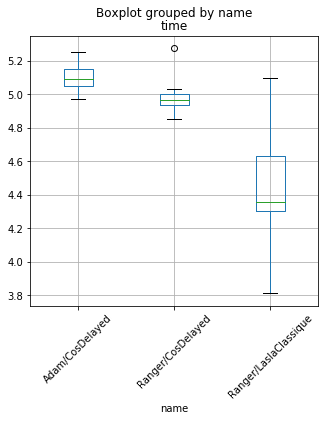

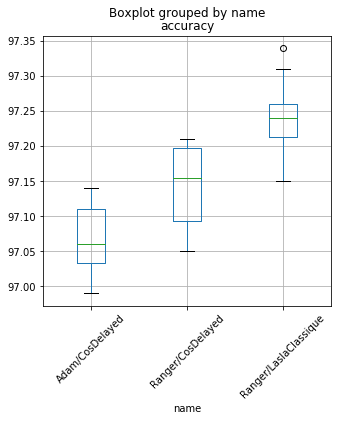

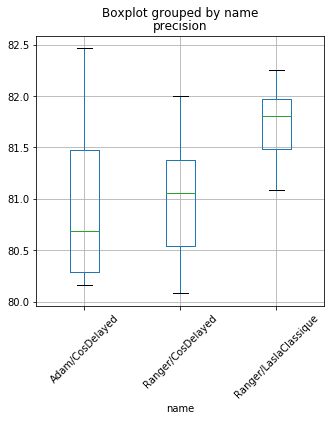

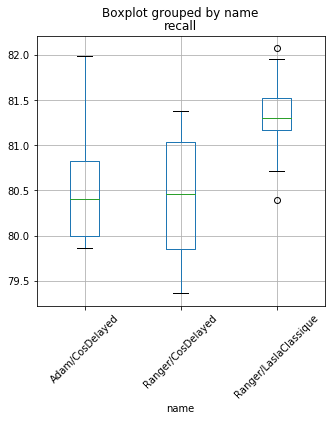

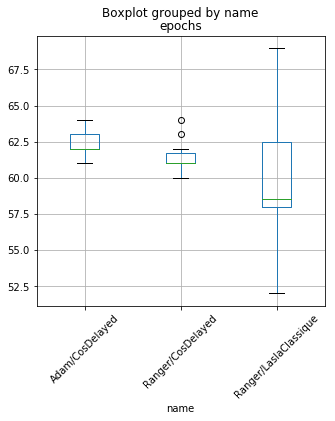

In [3]:
%matplotlib inline

from pandas import DataFrame
import matplotlib.pyplot as plt

plt.rcParams['axes.facecolor'] = 'white'

df = DataFrame([
    dict(name=model[0], **value)
    for model, value in models.items()
])
size = (5, 5)
df["time"] = df["time"] / 60
fig, ax = plt.subplots(figsize=size)
plt.suptitle('')
fig.set_facecolor("white")
df.boxplot(column=['time'], by='name', ax=ax)
plt.xticks(rotation=45)

fig, ax = plt.subplots(figsize=size)
plt.suptitle('')
fig.set_facecolor("white")
df.boxplot(column=['accuracy'], by='name', ax=ax)
plt.xticks(rotation=45)

fig, ax = plt.subplots(figsize=size)
plt.suptitle('')
fig.set_facecolor("white")
df.boxplot(column=['precision'], by='name', ax=ax)
plt.xticks(rotation=45)


fig, ax = plt.subplots(figsize=size)
plt.suptitle('')
fig.set_facecolor("white")
df.boxplot(column=['recall'], by='name', ax=ax)
plt.xticks(rotation=45)



fig, ax = plt.subplots(figsize=size)
plt.suptitle('')
fig.set_facecolor("white")
df.boxplot(column=['epochs'], by='name', ax=ax)
plt.xticks(rotation=45)

df.sort_values(by="accuracy")

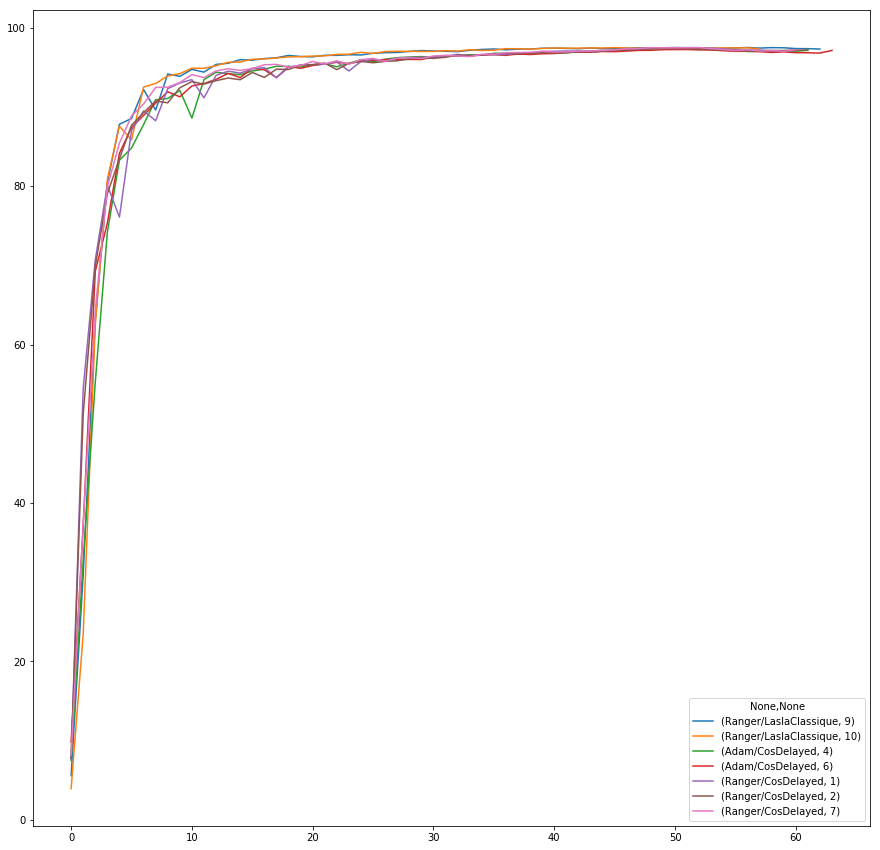

In [4]:

from pandas import Series
from collections import defaultdict

best = defaultdict(lambda: [])

for model, value in models.items():
    best[model[0]].append(value["accuracy"])
    
best = {key: sorted(value, reverse=True) for key, value in best.items()}
top = 2
accuracy_lists = {
    model: Series(value["accuracy_list"])
    for model, value in models.items()
    if value["accuracy"] in best[model[0]][:top]
}

fig, ax = plt.subplots(figsize=(15,15))
plt.suptitle('')
fig.set_facecolor("white")
DataFrame(accuracy_lists).plot(ax=ax)


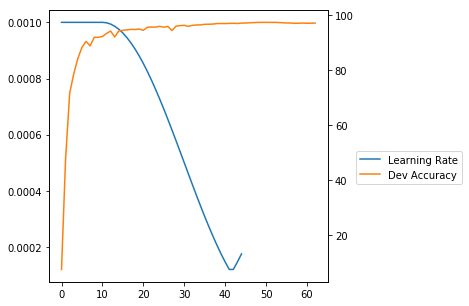

In [5]:
fig, ax = plt.subplots(figsize=(5,5))
plt.suptitle('')
fig.set_facecolor("white")
Series(models[('Ranger/CosDelayed', '5')]["lrs"]).plot(ax=ax)
Series(models[('Ranger/CosDelayed', '5')]["accuracy_list"]).plot(ax=ax, secondary_y=True)

ax.legend(
    [ax.get_lines()[0], ax.right_ax.get_lines()[0]],
    ['Learning Rate', 'Dev Accuracy'],
    bbox_to_anchor=(1.5, 0.5)
)
